Import neccessary libraries and functions.

In [10]:
#Put all the libraries here
import numpy as np

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset, Subset

from sklearn.datasets import load_wine
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split


import matplotlib as mpl
import matplotlib.pyplot as plt


#Define the training function
def train(epoch, model, train_dataloader, optimizer, lossfunction):
    model.train()
    
    train_loss = 0.0
    train_total, train_correct = 0.0, 0.0 
    
    for X_batch, y_batch in train_dataloader:
        optimizer.zero_grad()

        #Get the predicted output
        predictions = model(X_batch)

        #Calculate the loss
        loss = lossfunction(predictions, y_batch)
        
        #Update the weights usning gradient descent with Adam optimizer
        loss.backward()
        optimizer.step()
        
        #Convert probabilities to multi-class predictions (reutrn the class with the maximal proability)
        _, train_predicted = torch.max(predictions.data, 1)
        
        #Calculate the training statistics
        train_loss += loss.item()
        train_total += y_batch.size(0)
        train_correct += (train_predicted == y_batch).sum().item()

    print("epoch (%d): Train accuracy: %.4f, loss: %.3f" % (epoch, train_correct/train_total, train_loss/train_total))

#Define the test function for test_dataloader
def test(model, test_dataloader):
    model.eval()
    
    test_correct, test_total = 0.0, 0.0
    y_test, y_pred = [], []
    
    with torch.no_grad():
        for X_batch, y_batch in test_dataloader:
            predictions = model(X_batch)
            
            _, test_predicted = torch.max(predictions.data, 1)
            test_total += y_batch.size(0)
            test_correct += (test_predicted == y_batch).sum().item()
            
            y_test += y_batch.tolist()
            y_pred += test_predicted.tolist()

    print('Test accuracy: %.4f' % (test_correct / test_total))
    
    return y_test, y_pred

#Define the function that returns a predicted label for single input sample
def predict_label(model, single_input):
    model.eval()  
    with torch.no_grad():
        prediction = model(single_input)
        _, predicted_label = torch.max(prediction.data, 1)
    
    return predicted_label

#Define the function that returns predicted probabilities for single input sample
def predict_probabilities(model, single_input):
    model.eval()  
    with torch.no_grad():
        prediction = model(single_input)
        predicted_probabilities = torch.softmax(prediction, dim=1).squeeze(0)
    
    return predicted_probabilities

#Define the function that returns model weight vector that is used to predict the target_label
def weight_vector(model, target_label):
    model.eval()
    with torch.no_grad():
        weights = list(model.parameters())[0]
    
    return weights[target_label]

#Define the function that plots the given images
def plot_digits(instances, labels, images_per_row=5):
    for i in range(len(instances)):
        idx = i // images_per_row
        idy = i % images_per_row 
        ax[idx, idy].imshow(instances[i].squeeze(), cmap="gray")
        ax[idx, idy].set_title(class_names[labels[i]])
        ax[idx, idy].axis("off")

Download the Fashion-MNIST data.

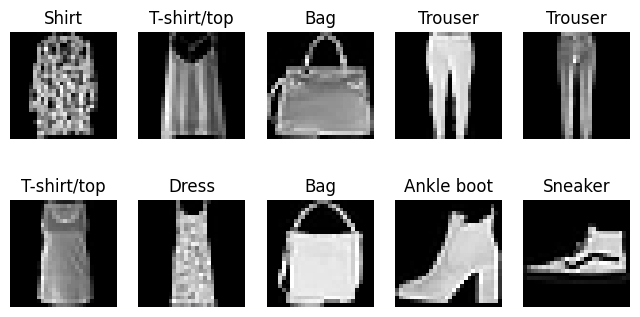

In [11]:
#Convert the dataset into Tensor used by PyTorch
transform=transforms.Compose([
         transforms.ToTensor(),
        ])

#Download the Fashion-MNIST data directly from PyTorch
#The downloaded datasets are stored in data folder under the same folder with this jupyter notebook file
train_dataset = datasets.FashionMNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST('./data', train=False, download=True, transform=transform)

#Load the datasets into DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=0)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=0)

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

#Plot some Fashion-MNIST examples
fig, ax = plt.subplots(2, 5, figsize=(8, 4))
dataiter = iter(train_dataloader)
samples = next(dataiter)
example_images = samples[0][:10]
example_labels = samples[1][:10]
plot_digits(example_images, example_labels, images_per_row=5)
plt.show()

Set up the epochs and construct the convolutional neural network.

In [16]:
#Set the random seed
torch.manual_seed(42)

#Code here: based on your computing resources, assign epochs as a number in the range of [5, 10]  
epochs = 10            
learning_rate = 0.01
weight_decay = 5e-4
lossfunction = nn.CrossEntropyLoss()          

#Code here: define a class CNN to construct all the layers in the convolutional neural network
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)    #Convolution: 1 input channel to 10 channels with kernel_size 5
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)   #Convolution: 10 channels to 20 channels with kernel_size 5
        self.fc1 = nn.Linear(320, 50)     #Fully-connected layer: 320 neurons to 50 neurons 
        self.fc2 = nn.Linear(50, 10)     #Fully-connected layer: 50 neurons to 10 neurons
        ##Add dropout
        self.dropout1 = nn.Dropout(p=0.5)  # Dropout with 50% probability
        self.dropout2 = nn.Dropout(p=0.5)  # Dropout with 50% probability

    def forward(self, x):
        x = F.relu(self.conv1(x))                     #The first convolution layer using ReLU activation function
        x = F.max_pool2d(x, 2)                        #The first pooling layer using max and pooling size is 2x2
        x = F.relu(self.conv2(x))                     #The second convolution layer using ReLU activation function
        x = F.max_pool2d(x, 2)                        #The second pooling layer using max and pooling size is 2x2
        x = torch.flatten(x, 1)                       #Flattern all channels into a feature vector
        x = F.relu(self.fc1(x))                       #The first fully-connected layer
        x = self.dropout1(x)
        x = self.fc2(x)     
        x = self.dropout2(x)                             
                                        
        return x

def answer_five():    
    #Code here: instantiate a CNN model from the defined CNN class  
    model = CNN()
    
    #Code here: specify the optimizer used for mini-batch gradient descent for model training
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    
    #Train the model
    for epoch in range(1, epochs + 1):
        #Code here: call train() function for model training: you need to pass the corresponding parameters to this function
        train(epoch, model, train_dataloader, optimizer, lossfunction)
        
    
    #Test the model: 
    #Code here: call test() function to evaluate the trained model: you need to pass the corresponding parameters to this function
    y_test, y_pred = test(model, test_dataloader)
    
    #Code here: use y_test and y_pred to calculate the macro F1 and micro F1 using sklearn function
    macrof1 = f1_score(y_test, y_pred, average='macro')
    microf1 = f1_score(y_test, y_pred, average='micro')
    print(macrof1)
    print(microf1)
    
    return model, macrof1, microf1

#Run your function in the cell to return the results
model, macrof1, microf1 = answer_five()

epoch (1): Train accuracy: 0.4278, loss: 0.023
epoch (2): Train accuracy: 0.4642, loss: 0.021
epoch (3): Train accuracy: 0.4753, loss: 0.021
epoch (4): Train accuracy: 0.4792, loss: 0.021
epoch (5): Train accuracy: 0.4819, loss: 0.020
epoch (6): Train accuracy: 0.4867, loss: 0.020
epoch (7): Train accuracy: 0.4895, loss: 0.020
epoch (8): Train accuracy: 0.4948, loss: 0.020
epoch (9): Train accuracy: 0.4955, loss: 0.020
epoch (10): Train accuracy: 0.4957, loss: 0.020
Test accuracy: 0.8122
0.8047457452218854
0.8122


Implement a fast gradient sign method attack.

In [17]:
def answer_six(epsilon, image_input, true_label):
    #Set requires_grad attribute of image_input tensor as true, which will be used to get the gradient
    image_input.requires_grad = True
    
    #Code here: pass the input image through the trained model to get the output
    prediction = model(image_input)

    #Code here: calculate the loss
    loss = lossfunction(prediction, true_label)

    #Code here: zero all existing gradients
    model.zero_grad()

    #Code here: calculate gradients of loss in backward pass
    loss.backward()

    #Code here: obtain the gradient regarding input image
    image_input_grad = image_input.grad.data

    #Perform FGSM attack
    #Code here: obtain the sign of the gradient
    sign_grad = image_input_grad.sign()

    #Code here: generate the perturbed image by adding the perturbation with epsilon and sign of gradient to the input image
    perturbed_image = image_input + epsilon * sign_grad

    #Code here: add clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)

    return perturbed_image 

Call the implemented attack and generate the adversarial examples.


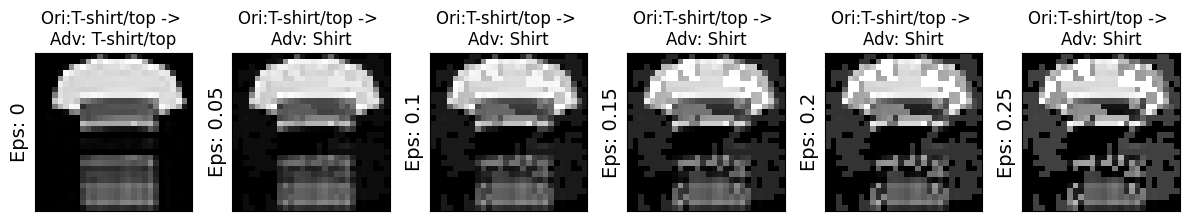

In [18]:
#epsilons for the size of perturbation
epsilons = [0, .05, .1, .15, .2, .25]

#Choose a random test image as input
#Set the random seed
np.random.seed(42)
#Number of test samples
number_of_images = len(test_dataset)
#Get a random index from [0, number_of_samples)
image_index = np.random.randint(number_of_images, size=1)

#Select the test input to perturb
test_images = torch.stack([test_dataset[i][0] for i in image_index])
test_imagelabels = torch.tensor([test_dataset[i][1] for i in image_index])

def answer_seven():
    adversarial_examples = []
    true_labels = []
    adv_labels = []

    for epsilon in epsilons:
        #Code here: call answer_six() to generate the perturbed image: you need to pass the corresponding parameters to this function
        perturbed_image = answer_six(epsilon, test_images, test_imagelabels)
        #Code here:: use predict_label() to classify the perturbed image
        adv_label = predict_label(model, perturbed_image)
    
        adversarial_examples.append(perturbed_image.detach().numpy())
        true_labels.append(test_imagelabels)
        adv_labels.append(adv_label)
    
    return adversarial_examples, true_labels, adv_labels

#Run your function in the cell to return the results
adversarial_examples, true_labels, adv_labels = answer_seven()

#Plot adversarial example at each epsilon
plt.figure(figsize=(12,20))
for i in range(len(epsilons)):
    plt.subplot(1, len(epsilons), i + 1)
    plt.xticks([], [])
    plt.yticks([], [])
    plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
    orig, adv, ex = true_labels[i], adv_labels[i], adversarial_examples[i][0].squeeze(0) 
    plt.title("Ori:{} -> \nAdv: {}".format(class_names[orig], class_names[adv]))
    plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()